# Import Libraries

In [1]:
!pip install nltk
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [106]:
import numpy as np
import pandas as pd
import sklearn as sk

import string
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Loading Dataset

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/harryzcy/COMP562-project/main/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


# Data Visualization

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

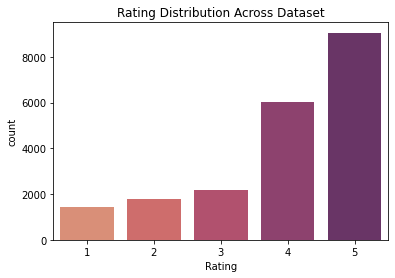

In [5]:
sns.countplot(data=df, x='Rating', palette='flare').set_title('Rating Distribution Across Dataset')

# Data Cleaning and Text Processing

In [6]:
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [7]:
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

In [8]:
df['Rating'] = df['Rating'].apply(rating)

In [9]:
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,Good,593
1,ok nothing special charge diamond member hilto...,Bad,1689
2,nice rooms not 4* experience hotel monaco seat...,Netral,1427
3,"unique, great stay, wonderful time hotel monac...",Good,600
4,"great stay great stay, went seahawk game aweso...",Good,1281


In [10]:
length = df['Length'].sum()

In [15]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

In [16]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [17]:
df['Review'] = df['Review'].apply(cleaning)

In [121]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 14853861
Total text length after cleaning: 13543965


In [122]:
df.to_csv('cleaned_df.csv', index=False)

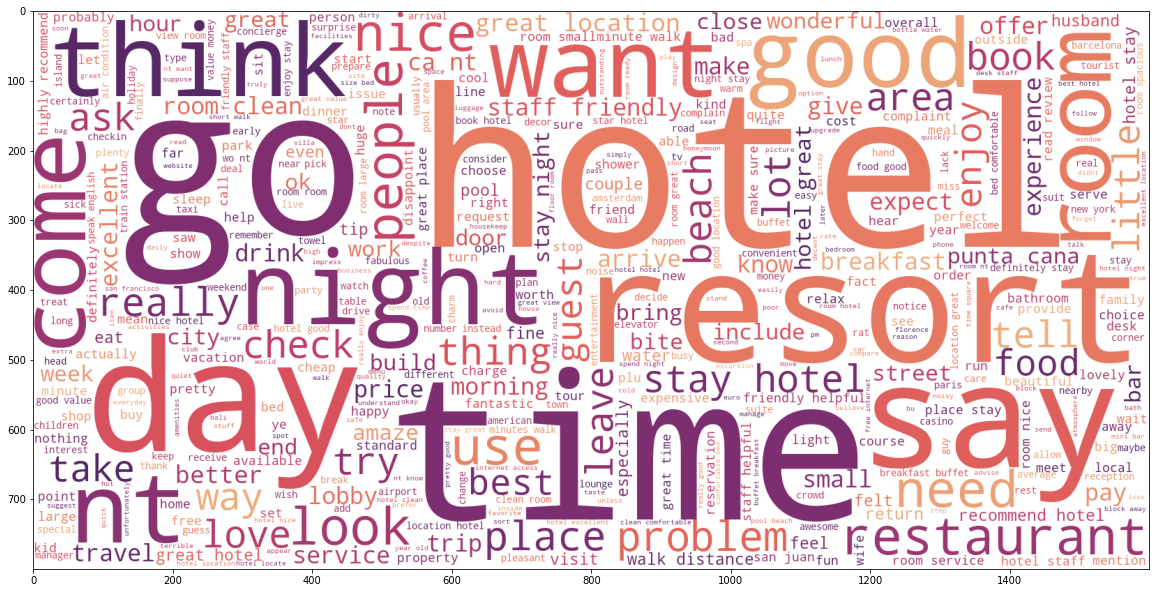

In [123]:
# After cleaning, we could see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['Review']))

plt.imshow(wc)

# Train and Test Datasets

In [124]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [125]:
train.shape

(16392, 3)

In [126]:
test.shape

(4099, 3)

In [127]:
X_train = train['Review']
y_train = train['Rating']
X_test = test['Review']
y_test = test['Rating']

# Models

In [128]:
models = {}
result = {}

In [129]:
def train_and_test(pipeline, name: str):
  pipeline.fit(X=X_train, y=y_train)
  y_pred = pipeline.predict(X_test)
  report = classification_report(y_test, y_pred)
  print(report)
  result[name] = accuracy_score(y_test, y_pred)
  models[name] = pipeline

Naive Bayes

In [130]:
NaiveBayes_Count = make_pipeline(CountVectorizer(min_df=0.005, max_df = 0.85), MultinomialNB())
train_and_test(NaiveBayes_Count, 'NaiveBayes_Count')

              precision    recall  f1-score   support

         Bad       0.71      0.71      0.71       625
        Good       0.93      0.89      0.91      3042
      Netral       0.35      0.45      0.40       432

    accuracy                           0.82      4099
   macro avg       0.66      0.68      0.67      4099
weighted avg       0.83      0.82      0.82      4099



In [131]:
NaiveBayes_Tfidf = make_pipeline(TfidfVectorizer(min_df=0.005, max_df = 0.85), MultinomialNB())
train_and_test(NaiveBayes_Tfidf, 'NaiveBayes_Tfidf')

              precision    recall  f1-score   support

         Bad       0.85      0.54      0.66       625
        Good       0.82      0.99      0.90      3042
      Netral       0.00      0.00      0.00       432

    accuracy                           0.82      4099
   macro avg       0.56      0.51      0.52      4099
weighted avg       0.74      0.82      0.77      4099



K-Nearest Neighbors

In [132]:
# KNeighborsClassifier with neighbor number 3
KNeighbors_Count = make_pipeline(CountVectorizer(min_df=0.005, max_df = 0.85), KNeighborsClassifier(3))
train_and_test(KNeighbors_Count, 'KNeighbors_Count')

              precision    recall  f1-score   support

         Bad       0.49      0.31      0.38       625
        Good       0.79      0.94      0.86      3042
      Netral       0.24      0.06      0.09       432

    accuracy                           0.75      4099
   macro avg       0.51      0.43      0.44      4099
weighted avg       0.69      0.75      0.70      4099



In [133]:
# KNeighborsClassifier with neighbor number 3
KNeighbors_Tfidf = make_pipeline(TfidfVectorizer(min_df=0.005, max_df = 0.85), KNeighborsClassifier(3))
train_and_test(KNeighbors_Tfidf, 'KNeighbors_Tfidf')

              precision    recall  f1-score   support

         Bad       0.55      0.49      0.52       625
        Good       0.83      0.93      0.88      3042
      Netral       0.30      0.10      0.15       432

    accuracy                           0.77      4099
   macro avg       0.56      0.51      0.52      4099
weighted avg       0.73      0.77      0.75      4099



Decision Tree

In [134]:
DecisionTree_Count = make_pipeline(CountVectorizer(min_df=0.005, max_df = 0.85),  DecisionTreeClassifier())
train_and_test(DecisionTree_Count, 'DecisionTree_Count')

              precision    recall  f1-score   support

         Bad       0.54      0.55      0.55       625
        Good       0.85      0.85      0.85      3042
      Netral       0.20      0.19      0.20       432

    accuracy                           0.74      4099
   macro avg       0.53      0.53      0.53      4099
weighted avg       0.73      0.74      0.74      4099



In [135]:
DecisionTree_Tfidf = make_pipeline(TfidfVectorizer(min_df=0.005, max_df = 0.85),  DecisionTreeClassifier())
train_and_test(DecisionTree_Tfidf, 'DecisionTree_Tfidf')

              precision    recall  f1-score   support

         Bad       0.52      0.52      0.52       625
        Good       0.85      0.84      0.85      3042
      Netral       0.21      0.21      0.21       432

    accuracy                           0.73      4099
   macro avg       0.52      0.53      0.53      4099
weighted avg       0.73      0.73      0.73      4099



Random Forest

In [136]:
RandomForest_Count = make_pipeline(CountVectorizer(min_df=0.005, max_df = 0.85), RandomForestClassifier(n_estimators=200, n_jobs=-1))
train_and_test(RandomForest_Count, 'RandomForest_Count')

              precision    recall  f1-score   support

         Bad       0.88      0.50      0.64       625
        Good       0.81      1.00      0.89      3042
      Netral       1.00      0.01      0.01       432

    accuracy                           0.82      4099
   macro avg       0.90      0.50      0.52      4099
weighted avg       0.84      0.82      0.76      4099



In [137]:
RandomForest_Tfidf = make_pipeline(TfidfVectorizer(min_df=0.005, max_df = 0.85), RandomForestClassifier(n_estimators=200, n_jobs=-1))
train_and_test(RandomForest_Tfidf, 'RandomForest_Tfidf')

              precision    recall  f1-score   support

         Bad       0.86      0.48      0.62       625
        Good       0.81      1.00      0.89      3042
      Netral       1.00      0.01      0.03       432

    accuracy                           0.81      4099
   macro avg       0.89      0.50      0.51      4099
weighted avg       0.84      0.81      0.76      4099



In [138]:
result

{'NaiveBayes_Count': 0.8175164674310808,
 'NaiveBayes_Tfidf': 0.8192242010246401,
 'KNeighbors_Count': 0.7496950475725787,
 'KNeighbors_Tfidf': 0.7740912417662844,
 'DecisionTree_Count': 0.7370090265918516,
 'DecisionTree_Tfidf': 0.7287143205659917,
 'RandomForest_Count': 0.8172725054891437,
 'RandomForest_Tfidf': 0.8141010002439619}

Bidirectional LSTM

In [139]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df['Review'], df['Rating'], test_size=0.2)

In [140]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train2)

total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train2)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test2)
test_padded = pad_sequences(test_seq)

lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train2)
test_labels = lb.transform(y_test2)

Total distinct words: 64884


In [141]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(lb, open('label.pkl', 'wb'))

In [142]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(8, kernel_regularizer=l2(0.001),
                                                          bias_regularizer=l2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 8)           519072    
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               3200      
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 3)                 27        
                                                      

In [189]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=40, validation_data=(test_padded, test_labels))

Epoch 1/40
513/513 [==============================] - 61s 112ms/step - loss: 0.2965 - accuracy: 0.8745 - val_loss: 0.6783 - val_accuracy: 0.8197
Epoch 2/40
513/513 [==============================] - 56s 110ms/step - loss: 0.2909 - accuracy: 0.8782 - val_loss: 0.7261 - val_accuracy: 0.8231
Epoch 3/40
513/513 [==============================] - 56s 110ms/step - loss: 0.2837 - accuracy: 0.8802 - val_loss: 0.7287 - val_accuracy: 0.8214
Epoch 4/40
513/513 [==============================] - 57s 111ms/step - loss: 0.2819 - accuracy: 0.8845 - val_loss: 0.7503 - val_accuracy: 0.8202
Epoch 5/40
513/513 [==============================] - 57s 112ms/step - loss: 0.2673 - accuracy: 0.8894 - val_loss: 0.7771 - val_accuracy: 0.8190
Epoch 6/40
513/513 [==============================] - 57s 112ms/step - loss: 0.2725 - accuracy: 0.8917 - val_loss: 0.7646 - val_accuracy: 0.8185
Epoch 7/40
513/513 [==============================] - 57s 112ms/step - loss: 0.2733 - accuracy: 0.8943 - val_loss: 0.7109 - val_ac

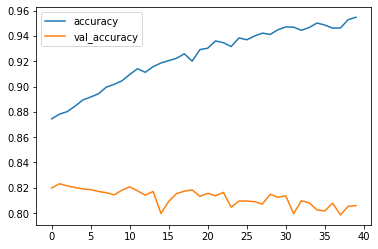

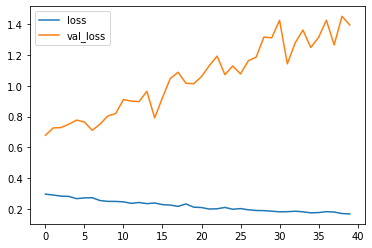

In [190]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [191]:
pred2 = model.predict(test_padded)

129/129 [==============================] - 6s 38ms/step


In [192]:
true_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(pred2, axis=-1)

In [193]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[ 439   94  117]
 [  82 2770  154]
 [ 129  220   94]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       650
           1       0.90      0.92      0.91      3006
           2       0.26      0.21      0.23       443

    accuracy                           0.81      4099
   macro avg       0.61      0.60      0.61      4099
weighted avg       0.79      0.81      0.80      4099



In [194]:
model.save('dl_model.h5')

# Prediction

In [195]:
# Logistic Regression
def ml_predict(text, pipeline):
    clean_text = cleaning(text)
    pred = pipeline.predict([clean_text])[0]
    return pred

# Deep Neural Network
def dl_predict(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [220]:
text = 'Excellent way stayed inn market memorial day weekend. The room is large and has great view. Great hotel great hotel, good sized'
for name, pipeline in models.items():
  print(f'Prediction using {name}: {ml_predict(text, pipeline)}')
print('Prediction using DNN: {}'.format(dl_predict(text)))

Prediction using NaiveBayes_Count: Good
Prediction using NaiveBayes_Tfidf: Good
Prediction using KNeighbors_Count: Good
Prediction using KNeighbors_Tfidf: Good
Prediction using DecisionTree_Count: Good
Prediction using DecisionTree_Tfidf: Good
Prediction using RandomForest_Count: Good
Prediction using RandomForest_Tfidf: Good
1/1 [==============================] - 0s 16ms/step
Prediction using DNN: Good


In [197]:
text2 = 'Disgusting room with bad smell'
for name, pipeline in models.items():
  print(f'Prediction using {name}: {ml_predict(text2, pipeline)}')
print('Prediction using DNN: {}'.format(dl_predict(text2)))

Prediction using NaiveBayes_Count: Bad
Prediction using NaiveBayes_Tfidf: Bad
Prediction using KNeighbors_Count: Good
Prediction using KNeighbors_Tfidf: Bad
Prediction using DecisionTree_Count: Bad
Prediction using DecisionTree_Tfidf: Bad
Prediction using RandomForest_Count: Bad
Prediction using RandomForest_Tfidf: Bad
1/1 [==============================] - 0s 18ms/step
Prediction using DNN: Bad


In [198]:
text3 = 'Hard to get there, and the room is small'
for name, pipeline in models.items():
  print(f'Prediction using {name}: {ml_predict(text3, pipeline)}')
print('Prediction using DNN: {}'.format(dl_predict(text3)))

Prediction using NaiveBayes_Count: Good
Prediction using NaiveBayes_Tfidf: Good
Prediction using KNeighbors_Count: Good
Prediction using KNeighbors_Tfidf: Bad
Prediction using DecisionTree_Count: Good
Prediction using DecisionTree_Tfidf: Bad
Prediction using RandomForest_Count: Good
Prediction using RandomForest_Tfidf: Good
1/1 [==============================] - 0s 18ms/step
Prediction using DNN: Bad


In [204]:
text4 = 'Hard to get here but the scenery is wonderful'
for name, pipeline in models.items():
  print(f'Prediction using {name}: {ml_predict(text4, pipeline)}')
print('Prediction using DNN: {}'.format(dl_predict(text4)))

Prediction using NaiveBayes_Count: Good
Prediction using NaiveBayes_Tfidf: Good
Prediction using KNeighbors_Count: Good
Prediction using KNeighbors_Tfidf: Good
Prediction using DecisionTree_Count: Good
Prediction using DecisionTree_Tfidf: Good
Prediction using RandomForest_Count: Good
Prediction using RandomForest_Tfidf: Good
1/1 [==============================] - 0s 18ms/step
Prediction using DNN: Netral
